<a href="https://colab.research.google.com/github/alexc6h6/Generative-Adversarial-Networks/blob/master/DC_GAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Dropout, Reshape, BatchNormalization, ReLU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from glob import glob
import cv2
import os
from google.colab.patches import cv2_imshow

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/digit_recognizer'

MNIST_model.h5	sample_submission.csv  test.csv  train.csv


In [0]:
data = pd.read_csv('/content/drive/My Drive/digit_recognizer/train.csv')

In [5]:
images = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
images = (images.astype('float32')-127.5)/127.5

print(images.shape)


(42000, 28, 28, 1)


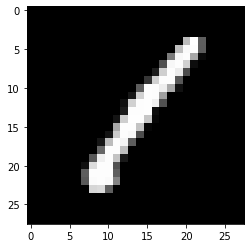

In [6]:
plt.imshow(images[0, :, :, 0], cmap = 'gray')

In [0]:
img_row, img_col, img_channels = 28, 28, 1
dim = 7
depth = 256
noise_dim = 100
adam = Adam(0.0002, 0.5)
batch_size = 64
steps_per_epoch = 1000
epochs = 10

In [0]:
def create_generator():
  generator = Sequential(name = 'generator')

  generator.add(Dense(dim*dim*depth, input_dim = noise_dim))
  generator.add(LeakyReLU(0.2))
  generator.add(Reshape((dim, dim, depth)))

  generator.add(Conv2DTranspose(depth/2, (3,3), padding = 'same', strides = 2))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  generator.add(Conv2DTranspose(depth/4, (3,3), padding = 'same', strides = 2))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(0.2))

  generator.add(Conv2DTranspose(img_channels, (3,3), padding = 'same', strides = 1, activation = 'tanh'))

  generator.compile(optimizer = adam, loss = 'binary_crossentropy')

  return generator

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 128)       295040    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 64)        73

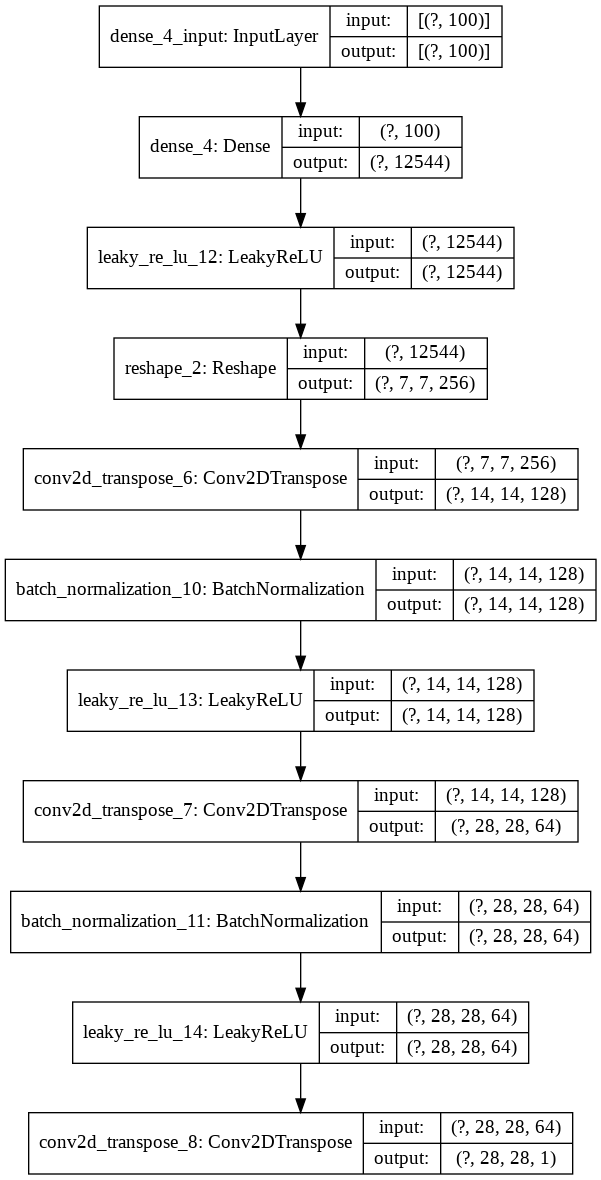

In [34]:
generator = create_generator()
generator.summary()
plot_model(generator, show_shapes = True)


In [0]:
def create_discriminator():
  discriminator = Sequential(name = 'discriminator')

  discriminator.add(Conv2D(depth/4, (3,3), strides = 2, padding = 'same', input_shape = (img_row, img_col, img_channels)))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(depth/2, (3,3), strides = 2, padding = 'same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(depth, (3,3), strides = 2, padding = 'same'))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Flatten())

  discriminator.add(Dense(1, activation = 'sigmoid'))

  discriminator.compile(optimizer = adam, loss = 'binary_crossentropy')

  return discriminator

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)       

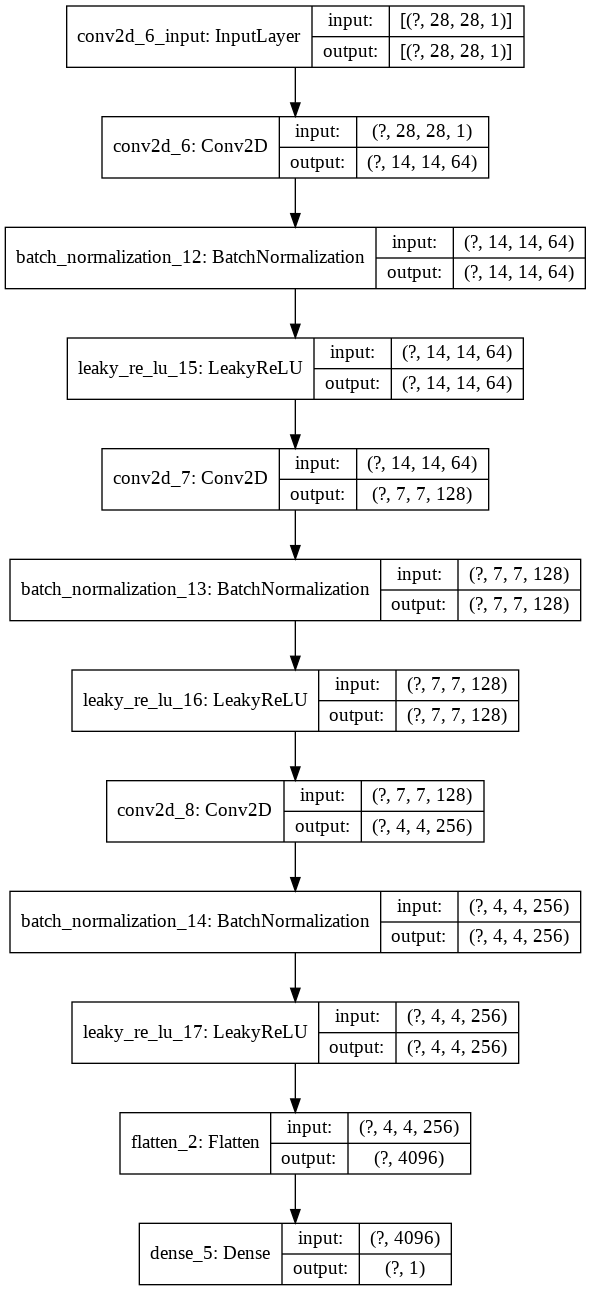

In [36]:
discriminator = create_discriminator()
discriminator.summary()
plot_model(discriminator, show_shapes = True)

Model: "gan_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         1637121   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 375553    
Total params: 2,012,674
Trainable params: 1,636,737
Non-trainable params: 375,937
_________________________________________________________________


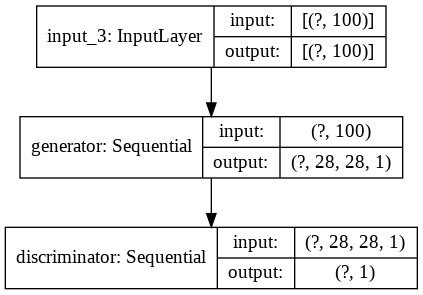

In [37]:
discriminator.trainable = False

gan_input = Input(shape = noise_dim,)
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)

gan = Model(gan_input, gan_output, name = 'gan_model')

gan.summary()

plot_model(gan, show_shapes = True)


In [0]:
gan.compile(optimizer = adam, loss = 'binary_crossentropy')


In [39]:
for epoch in range(epochs):
  for batch in range(steps_per_epoch):

    noise = np.random.normal(0, 1, size = (batch_size, noise_dim))

    fake_x = generator.predict(noise)
    real_x = images[np.random.randint(0, images.shape[0], size = batch_size)]
    x = np.concatenate((real_x, fake_x))

    disc_y = np.zeros(2*batch_size)
    disc_y[:batch_size] = 0.9

    discriminator_loss = discriminator.train_on_batch(x, disc_y)

    gan_y = np.ones(batch_size)

    gan_loss = gan.train_on_batch(noise, gan_y)

  print(f'Epoch: {epoch} \t Discriminator Loss: {discriminator_loss} \t Gan Loss: {gan_loss}')

Epoch: 0 	 Discriminator Loss: 0.20024870336055756 	 Gan Loss: 0.045660778880119324
Epoch: 1 	 Discriminator Loss: 0.16335368156433105 	 Gan Loss: 8.701885223388672
Epoch: 2 	 Discriminator Loss: 0.16290989518165588 	 Gan Loss: 9.078767776489258
Epoch: 3 	 Discriminator Loss: 0.3883739411830902 	 Gan Loss: 3.352992057800293
Epoch: 4 	 Discriminator Loss: 0.27309995889663696 	 Gan Loss: 0.14606258273124695
Epoch: 5 	 Discriminator Loss: 0.2531501352787018 	 Gan Loss: 0.10629764944314957
Epoch: 6 	 Discriminator Loss: 0.333778440952301 	 Gan Loss: 5.679945945739746
Epoch: 7 	 Discriminator Loss: 0.21258608996868134 	 Gan Loss: 16.549306869506836
Epoch: 8 	 Discriminator Loss: 0.19763287901878357 	 Gan Loss: 1.711159586906433
Epoch: 9 	 Discriminator Loss: 0.27288714051246643 	 Gan Loss: 7.386354446411133


In [0]:
def show_image(noise):
  generated_image = generator.predict(noise)
  plt.figure(figsize = (20, 20))

  for i, image in enumerate(generated_image):
    plt.subplot(10, 10, i+1)
    image = (image + 1) * 127.5
    image = image.astype('int32')
    plt.imshow(image.reshape(28, 28), cmap = 'gray')
    plt.axis('off')

  #plt.tight_layout()
  plt.show()

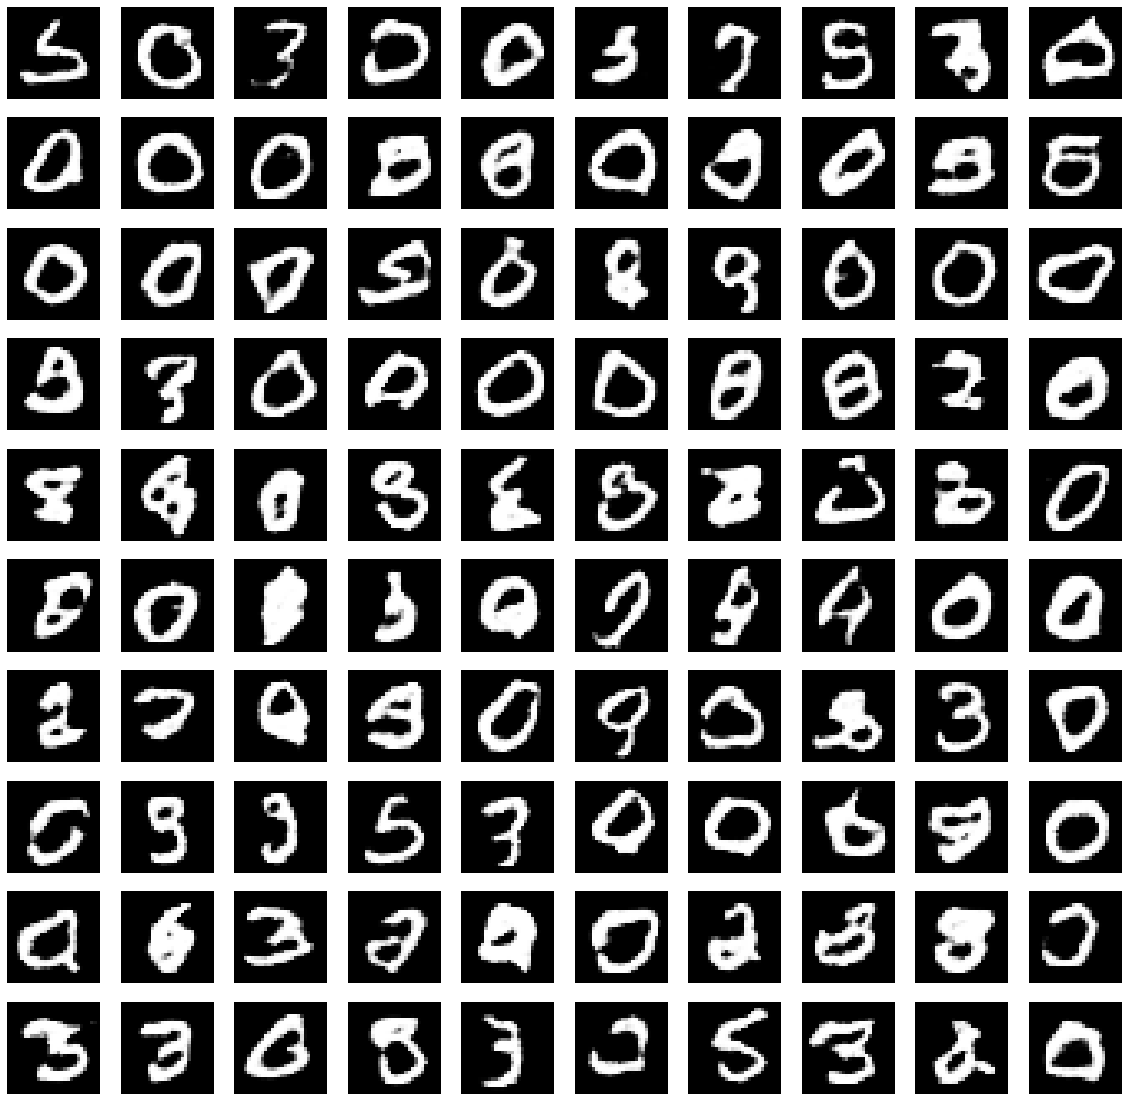

In [41]:
test_noise = np.random.normal(0, 1, size = (100, noise_dim))
show_image(test_noise)